In [98]:
import pandas as pd
import json
import gzip
# sudo pip install pandas


In [99]:
def json_gz_to_dataframe(gz_file_path):
    data = []
    
    # Open and read the gzipped JSON file
    with gzip.open(gz_file_path, 'rt') as file:
        # Read the file line-by-line
        for line in file:
            try:
                json_data = json.loads(line)  # Load each line as a separate JSON object
                
                # Loop through the transcripts in the JSON data
                for transcript_id, positions in json_data.items():
                    for position, sequences in positions.items():
                        for sequence, reads in sequences.items():
                            # Create the 5-mers for the position -1, 0, and 1 from the 7-mer (sequence)
                            fivemer_neg_1 = sequence[:5]  # First 5 nucleotides (e.g., "AAGAC")
                            fivemer_0 = sequence[1:6]     # Middle 5 nucleotides (e.g., "AGACC")
                            fivemer_1 = sequence[2:]      # Last 5 nucleotides (e.g., "GACCA")
                            
                            # For each read in the list of reads, create a row
                            for read in reads:
                                row = [
                                    transcript_id,                # transcript_id
                                    int(position)-1,              # position_neg_1
                                    read[0], read[1], read[2],    # dwelling_time_neg_1, sd_neg_1, mean_neg_1
                                    int(position),                # position_0
                                    read[3], read[4], read[5],    # dwelling_time_0, sd_0, mean_0
                                    int(position)+1,              # position_1
                                    read[6], read[7], read[8],    # dwelling_time_1, sd_1, mean_1
                                    sequence,                     # ori_nucleotide (7-mer)
                                    fivemer_neg_1,                # fivemer_neg_1
                                    fivemer_0,                    # fivemer_0
                                    fivemer_1                     # fivemer_1
                                ]
                                data.append(row)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON line: {line}")
    
    # Define the columns, including the new 5-mer and ori_nucleotide columns
    columns = [
        'transcript_id', 'position_neg_1', 'dwelling_time_neg_1', 'sd_neg_1', 'mean_neg_1',
        'position_0', 'dwelling_time_0', 'sd_0', 'mean_0',
        'position_1', 'dwelling_time_1', 'sd_1', 'mean_1',
        'ori_nucleotide', 'fivemer_neg_1', 'fivemer_0', 'fivemer_1'
    ]
    
    # Create the dataframe
    df = pd.DataFrame(data, columns=columns)
    
    return df

# Example usage
# df = json_gz_to_dataframe('dataset0.json.gz')  # Replace with actual path
# print(df.head())

In [100]:
df = json_gz_to_dataframe('data/dataset0.json.gz')  # Replace with actual path
print(df.head())

df.to_csv('data/dataset0.csv', index=False) # save file as csv


In [7]:
# Step 1: Read in the 'data.info.labelled' file
# Adjust 'sep' based on the format (e.g., ',' for CSV or '\t' for tab-separated files)
data_info = pd.read_csv('data/data.info.labelled', sep=',')

df = pd.read_csv('data/dataset0.csv')

data_info.rename(columns={'transcript_position': 'position_0'}, inplace=True)

# Step 2: Perform the merge using 'transcript_id'
merged_df = pd.merge(df, data_info, on=['transcript_id', 'position_0'], how='inner')

merged_df.to_csv('data/merged_df.csv', index=False)
# Step 3: Display the merged DataFrame
print(merged_df.head())

# studies/ProjectStorage/data/merged_df.csv


     transcript_id  position_neg_1  dwelling_time_neg_1  sd_neg_1  mean_neg_1  \
0  ENST00000000233             243              0.00299      2.06       125.0   
1  ENST00000000233             243              0.00631      2.53       125.0   
2  ENST00000000233             243              0.00465      3.92       109.0   
3  ENST00000000233             243              0.00398      2.06       125.0   
4  ENST00000000233             243              0.00664      2.92       120.0   

   position_0  dwelling_time_0   sd_0  mean_0  position_1  dwelling_time_1  \
0         244          0.01770  10.40   122.0         245          0.00930   
1         244          0.00844   4.67   126.0         245          0.01030   
2         244          0.01360  12.00   124.0         245          0.00498   
3         244          0.00830   5.01   130.0         245          0.00498   
4         244          0.00266   3.94   129.0         245          0.01300   

    sd_1  mean_1          gene_id  label  
0

In [8]:
# jupyter notebook --no-browser --ip=0.0.0.0 --port=8888


Normalise data

In [90]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# List of columns to scale
scaled_columns = [
    'dwelling_time_neg_1', 
    'sd_neg_1', 
    'mean_neg_1', 
    'dwelling_time_0', 
    'sd_0', 
    'mean_0', 
    'dwelling_time_1', 
    'sd_1', 
    'mean_1'
]

# Scale the selected columns
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])

# Check the modified DataFrame
print(df.head())


     transcript_id  position_neg_1  dwelling_time_neg_1  sd_neg_1  mean_neg_1  \
0  ENST00000000233             243            -0.945395 -0.887354    1.182045   
1  ENST00000000233             243            -0.331941 -0.705037    1.182045   
2  ENST00000000233             243            -0.638668 -0.165843   -0.159518   
3  ENST00000000233             243            -0.762467 -0.887354    1.182045   
4  ENST00000000233             243            -0.270965 -0.553752    0.762807   

   position_0  dwelling_time_0      sd_0    mean_0  position_1  \
0         244         1.801522  1.734026  0.838074         245   
1         244         0.054822 -0.170495  1.145105         245   
2         244         1.028145  2.265830  0.991589         245   
3         244         0.028414 -0.057487  1.452136         245   
4         244        -1.035450 -0.413131  1.375378         245   

   dwelling_time_1      sd_1    mean_1          gene_id  label  
0         0.506790  4.659152 -0.387623  ENSG0000000

In [93]:
# lag
lag_columns = [
    'dwelling_time_neg_1', 'sd_neg_1', 'mean_neg_1',
    'dwelling_time_0', 'sd_0', 'mean_0',
    'dwelling_time_1', 'sd_1', 'mean_1'
]
for lag in range(1, 4):
    for col in lag_columns:
        merged_df[f'lag_{lag}_{col}'] = merged_df.groupby(['transcript_id', 'position_0'])[col].shift(lag)
merged_df.fillna(0, inplace=True)  # Replace NaNs with 0

In [95]:
# rolling mean
def compute_rolling_statistics(group, window=3):
    for col in [
        'dwelling_time_neg_1', 'sd_neg_1', 'mean_neg_1',
        'dwelling_time_0', 'sd_0', 'mean_0',
        'dwelling_time_1', 'sd_1', 'mean_1'
    ]:
        group[f'rolling_mean_{col}'] = group[col].rolling(window=window, min_periods=1).mean()
        group[f'rolling_sd_{col}'] = group[col].rolling(window=window, min_periods=1).std()  # Standard deviation
        group[f'dwelling_time_{col}'] = group[col].rolling(window=window, min_periods=1).mean()
    return group



merged_df = merged_df.groupby(['transcript_id', 'position_0']).apply(compute_rolling_statistics)


KeyboardInterrupt: 

In [ ]:
merged_df.shape

In [27]:
### EDA###

import matplotlib.pyplot as plt
import seaborn as sns

# Example: Scatter plot of current mean vs lagged mean
def plot(merged_df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=merged_df['mean_0'], y=merged_df['lag_1_mean_0'])
    plt.title('Current Mean vs Lagged Mean')
    plt.xlabel('Mean at Position 0')
    plt.ylabel('Lagged Mean at Position 0')
    plt.show()


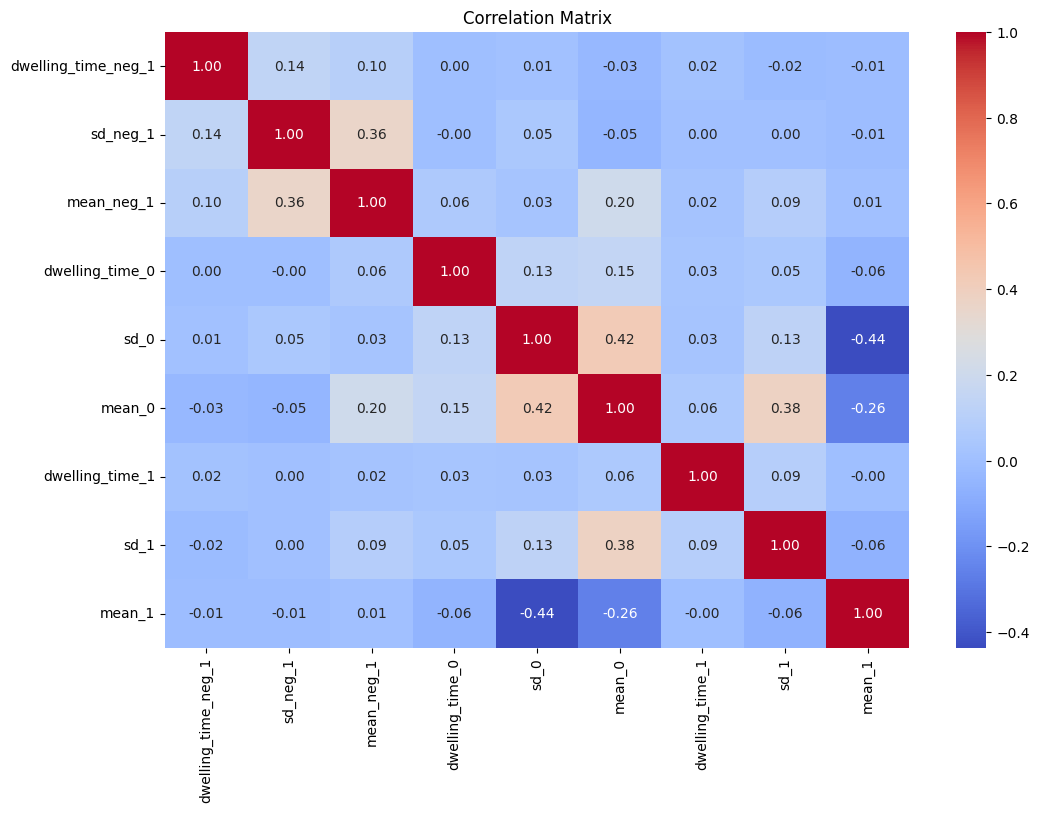

In [28]:
relevant_columns = [
    'dwelling_time_neg_1', 'sd_neg_1', 'mean_neg_1',
    'dwelling_time_0', 'sd_0', 'mean_0',
    'dwelling_time_1', 'sd_1', 'mean_1'
]

for col in relevant_columns:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# Calculate the correlation matrix for relevant columns
correlation_matrix = merged_df[relevant_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [19]:
# merged_df.to_csv("merged_norm_lag.csv",  index=False)

: 

### Start from here

In [7]:
# Change this file path
import pandas as pd
df = pd.read_csv("~/Desktop/NUS/Y4/DSA4262/Team_Project/data/merged_data.csv")
# df = pd.read_csv("studies/ProjectStorage/data/merged_data.csv")
df.head()


,transcript_id,position_neg_1,dwelling_time_neg_1,sd_neg_1,mean_neg_1,transcript_position,dwelling_time_0,sd_0,mean_0,position_1,dwelling_time_1,sd_1,mean_1,ori_nucleotide,fivemer_neg_1,fivemer_0,fivemer_1,gene_id,label
0,ENST00000000233,243,0.00299,2.06,125.0,244,0.01770,10.40,122.0,245,0.00930,10.90,84.1,AAGACCA,AAGAC,AGACC,GACCA,ENSG00000004059,0
1,ENST00000000233,243,0.00631,2.53,125.0,244,0.00844,4.67,126.0,245,0.01030,6.30,80.9,AAGACCA,AAGAC,AGACC,GACCA,ENSG00000004059,0
2,ENST00000000233,243,0.00465,3.92,109.0,244,0.01360,12.00,124.0,245,0.00498,2.13,79.6,AAGACCA,AAGAC,AGACC,GACCA,ENSG00000004059,0
3,ENST00000000233,243,0.00398,2.06,125.0,244,0.00830,5.01,130.0,245,0.00498,3.78,80.4,AAGACCA,AAGAC,AGACC,GACCA,ENSG00000004059,0
4,ENST00000000233,243,0.00664,2.92,120.0,244,0.00266,3.94,129.0,245,0.01300,7.15,82.2,AAGACCA,AAGAC,AGACC,GACCA,ENSG00000004059,0


In [8]:
df.columns

Index(['transcript_id', 'position_neg_1', 'dwelling_time_neg_1', 'sd_neg_1',
       'mean_neg_1', 'transcript_position', 'dwelling_time_0', 'sd_0',
       'mean_0', 'position_1', 'dwelling_time_1', 'sd_1', 'mean_1',
       'ori_nucleotide', 'fivemer_neg_1', 'fivemer_0', 'fivemer_1', 'gene_id',
       'label'],
      dtype='object')

### Splitting the dataset

In [24]:
from sklearn.model_selection import GroupShuffleSplit

X = df.drop(columns=['transcript_id', 'gene_id', 'label'])
y = df['label']
groups = df['gene_id']  # Keep gene_id for grouping purposes

# Step 1: Split the data into training and testing sets based on gene_id
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


### Feature Selection via Random Forest

In [25]:
# Identify categorical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical features:", categorical_features)

# Frequency Encoding for Categorical Features
def frequency_encoding(df, column):
    freq = df[column].value_counts() / len(df)
    df[column + '_freq'] = df[column].map(freq)
    df.drop(columns=[column], inplace=True)
    return df

# Apply frequency encoding to the training and test sets
for col in categorical_features:
    X_train = frequency_encoding(X_train, col)
    X_test = frequency_encoding(X_test, col) 

# Ensure the same columns exist in both sets
# X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

Categorical features: ['ori_nucleotide', 'fivemer_neg_1', 'fivemer_0', 'fivemer_1']


/var/folders/r7/7xn5t9gj65x3tw58b7rmvtmm0000gn/T/ipykernel_26596/1345640379.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column + '_freq'] = df[column].map(freq)
/var/folders/r7/7xn5t9gj65x3tw58b7rmvtmm0000gn/T/ipykernel_26596/1345640379.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=[column], inplace=True)
/var/folders/r7/7xn5t9gj65x3tw58b7rmvtmm0000gn/T/ipykernel_26596/1345640379.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [26]:
print("After Frequency Encoding:")
print(X_train.head())
print(X_test.head())

After Frequency Encoding:
   position_neg_1  dwelling_time_neg_1  sd_neg_1  mean_neg_1  \
0             243              0.00299      2.06       125.0   
1             243              0.00631      2.53       125.0   
2             243              0.00465      3.92       109.0   
3             243              0.00398      2.06       125.0   
4             243              0.00664      2.92       120.0   

   transcript_position  dwelling_time_0   sd_0  mean_0  position_1  \
0                  244          0.01770  10.40   122.0         245   
1                  244          0.00844   4.67   126.0         245   
2                  244          0.01360  12.00   124.0         245   
3                  244          0.00830   5.01   130.0         245   
4                  244          0.00266   3.94   129.0         245   

   dwelling_time_1   sd_1  mean_1  ori_nucleotide_freq  fivemer_neg_1_freq  \
0          0.00930  10.90    84.1              0.00736            0.060187   
1          0

In [33]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

def rf_feature_selector(X,y):
    model = RandomForestClassifier()
    model.fit(X, y)
    importances = model.feature_importances_
    # Visualize feature importances
    feature_importances = pd.Series(importances, index=X.columns)
    top_features = feature_importances.nlargest(10).index.tolist()
    X_selected = X[top_features]
    return X_selected, top_features

In [34]:
X_selected, top_features = rf_feature_selector(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
# Update feature sets with selected features from Random Forest
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

### Apply SMOTE

In [ ]:
# See class distribution before SMOTE
print("Class distribution in training set before SMOTE:")
print(y_train.value_counts())

# label                                                                           
# 0    93715                                                                      
# 1     4291 

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_selected_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)
print("Class distribution in training set after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())
#  Both Label 0 and 1: 93715 each                                                                       

### Model Training and Fitting

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC
import copy
# Setting up the pipelines for various models
pipelines = {
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42)),
#     'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=100, random_state=42)),
#     'xgb': make_pipeline(StandardScaler(), xgb.XGBClassifier(n_estimators=100, random_state=42)),
#     'svm': make_pipeline(StandardScaler(), SVC())
}

In [ ]:
print("Training and evaluating models with all features:")
# Fit models with all features
for name, pipeline in pipelines.items():
    pipeline.fit(X_train_resampled, y_train_resampled)
    # Evaluate model performance
    train_score = pipeline.score(X_train_resampled, y_train_resampled)
    print(f"{name}: Training Score: {train_score}")

In [ ]:
pipelines_selected = {name: copy.deepcopy(pipeline) for name, pipeline in pipelines.items()}

print("\nTraining and evaluating models with selected features:")
# Fit models with selected features
for name, pipeline in pipelines_selected.items():
    pipeline.fit(X_train_selected_resampled, y_train_resampled)
    # Evaluate model performance
    train_score = pipeline.score(X_train_selected_resampled, y_train_resampled)
    print(f"{name}: Training Score: {train_score}")

### Model Evaluation

Test with all features selected

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
auc_scores = []

for name, pipeline in pipelines.items():

    y_pred = pipeline.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    y_probs = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Append scores to lists
    accuracy_scores.append((name, accuracy))
    precision_scores.append((name, precision))
    recall_scores.append((name, recall))
    f1_scores.append((name, f1))
    auc_scores.append((name, roc_auc))

    # Plotting the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for {name}:\n", cm)


# Print evaluation metrics
print("Accuracy:")
for name, score in accuracy_scores:
    print(f"{name}: {score}")

print("\nPrecision:")
for name, score in precision_scores:
    print(f"{name}: {score}")

print("\nRecall:")
for name, score in recall_scores:
    print(f"{name}: {score}")

print("\nF1:")
for name, score in f1_scores:
    print(f"{name}: {score}")

print("\nAUC):")
for name, score in auc_scores:
    print(f"{name}: {score}")

Test with feature selected columns

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
auc_scores = []

for name, pipeline in pipelines_selected.items():

    y_pred = pipeline.predict(X_test_selected)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    y_probs = pipeline.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Append scores to lists
    accuracy_scores.append((name, accuracy))
    precision_scores.append((name, precision))
    recall_scores.append((name, recall))
    f1_scores.append((name, f1))
    auc_scores.append((name, roc_auc))

    # Plotting the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for {name}:\n", cm)


# Print evaluation metrics
print("Accuracy:")
for name, score in accuracy_scores:
    print(f"{name}: {score}")

print("\nPrecision:")
for name, score in precision_scores:
    print(f"{name}: {score}")

print("\nRecall:")
for name, score in recall_scores:
    print(f"{name}: {score}")

print("\nF1:")
for name, score in f1_scores:
    print(f"{name}: {score}")

print("\nAUC):")
for name, score in auc_scores:
    print(f"{name}: {score}")

Visualise Metrics

In [ ]:
# Define model names and scores
models = [name for name, _ in accuracy_scores]
accuracy_values = [score for _, score in accuracy_scores]
recall_values = [score for _, score in recall_scores]


# Create subplots for each metric
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot MAE
axes[0].bar(models, accuracy_values, color='blue')
axes[0].set_title('Accuracy')
axes[0].set_ylabel('Accuracy')

# Plot RMSE
axes[1].bar(models,recall_values , color='green')
axes[1].set_title('Recall')
axes[1].set_ylabel('Recall')


# Rotate x-axis labels for better readability
for ax in axes:
    ax.set_xticklabels(models, rotation=45)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Hyperparameter Tuning

In [ ]:
from scipy.stats import randint, uniform

# Setting up parameter distributions for each tunable classifier
param_distributions = {
    'rf': {
        'randomforestclassifier__n_estimators': randint(100, 500),
        'randomforestclassifier__max_features': uniform(0.1, 0.9),
        'randomforestclassifier__max_depth': randint(3, 30),
        'randomforestclassifier__min_samples_split': randint(2, 20),
        'randomforestclassifier__min_samples_leaf': randint(1, 20)
    },
    # 'gb': {
    #     'gradientboostingclassifier__n_estimators': randint(100, 500),
    #     'gradientboostingclassifier__learning_rate': uniform(0.01, 0.3),
    #     'gradientboostingclassifier__max_depth': randint(3, 15)
    # },
    # 'xgb': {
    #     'xgbclassifier__n_estimators': randint(100, 500),
    #     'xgbclassifier__learning_rate': uniform(0.01, 0.3),
    #     'xgbclassifier__max_depth': randint(3, 15),
    #     'xgbclassifier__min_child_weight': randint(1, 10),
    #     'xgbclassifier__colsample_bytree': uniform(0.5, 0.5)
    # },
    # 'svm': {
    #     'svc__C': uniform(0.1, 10),
    #     'svc__gamma': ['scale', 'auto'],
    #     'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    # }
}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
def optimize_pipelines(pipelines, param_distributions, X_train_selected, y_train):
    optimized_pipelines = {}

    # Perform hyperparameter tuning for each model
    for name, pipeline in pipelines.items():
        if name in param_distributions:
            print(f"Tuning hyperparameters for {name}...")
            # Create RandomizedSearchCV object
            # scoring=make_scorer(recall_score)
            random_search = RandomizedSearchCV(pipeline, param_distributions[name], scoring='recall', n_iter=20, cv=5, random_state=42, n_jobs=-1)
            # Fit RandomizedSearchCV
            random_search.fit(X_train_selected, y_train)
            # Print best parameters and best score
            print("Best parameters:", random_search.best_params_)
            print("Best score:", -random_search.best_score_)
            print()
            # Store the best estimator in the optimized pipelines dictionary
            optimized_pipelines[name] = random_search.best_estimator_

    return optimized_pipelines

In [ ]:
#  or use X_train_resampled
optimized_pipelines = optimize_pipelines(pipelines_selected, param_distributions, X_train_selected_resampled, y_train_resampled)

In [ ]:
accuracy_scores_optimized = []
precision_scores_optimized = []
recall_scores_optimized = []
f1_scores_optimized = []
auc_scores_optimized = []

for name, pipeline in optimized_pipelines.items():
    y_pred = pipeline.predict(X_test_selected)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    y_probs = pipeline.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Append scores to lists
    accuracy_scores_optimized.append((name, accuracy))
    precision_scores_optimized.append((name, precision))
    recall_scores_optimized.append((name, recall))
    f1_scores_optimized.append((name, f1))
    auc_scores_optimized.append((name, roc_auc))

    # Plotting the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for {name}:\n", cm)

print("After Hyperparameter tuning and Feature Selection")
# Print evaluation metrics
print("Accuracy:")
for name, score in accuracy_scores:
    print(f"{name}: {score}")

print("\nPrecision:")
for name, score in precision_scores:
    print(f"{name}: {score}")

print("\nRecall:")
for name, score in recall_scores:
    print(f"{name}: {score}")

print("\nF1:")
for name, score in f1_scores:
    print(f"{name}: {score}")

print("\nAUC):")
for name, score in auc_scores:
    print(f"{name}: {score}")

In [ ]:
# Plot
models_op = [name for name, _ in accuracy_scores_optimized]
accuracy_values_op = [score for _, score in accuracy_scores_optimized]
recall_values_op = [score for _, score in recall_scores_optimized]
auc_values_op = [score for _, score in auc_scores_optimized]

accuracy_values = [score for _, score in accuracy_scores]
recall_values = [score for _, score in recall_scores]
auc_values = [score for _, score in auc_scores]


# Create subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Set up bar width and index
bar_width = 0.35
index = range(len(models_op))

# Plot Accuracy
bar1 = axes[0].bar(index, accuracy_values, bar_width, color='red', label='Before Tuning')
bar2 = axes[0].bar([i + bar_width for i in index], accuracy_values_op, bar_width, color='blue', label='After Tuning')

axes[0].set_title('Model Accuracy')
axes[0].set_xticks([i + bar_width / 2 for i in index])
axes[0].set_xticklabels(models_op, rotation=45)
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot Recall
bar3 = axes[1].bar(index, recall_values, bar_width, color='orange', label='Before Tuning')
bar4 = axes[1].bar([i + bar_width for i in index], recall_values_op, bar_width, color='cyan', label='After Tuning')

axes[1].set_title('Model Recall')
axes[1].set_xticks([i + bar_width / 2 for i in index])
axes[1].set_xticklabels(models_op, rotation=45)
axes[1].set_ylabel('Recall')
axes[1].legend()

# Plot AUC
bar5 = axes[2].bar(index, auc_values, bar_width, color='green', label='Before Tuning')
bar6 = axes[2].bar([i + bar_width for i in index], auc_values_op, bar_width, color='purple', label='After Tuning')

axes[2].set_title('Area Under Curve (AUC)')
axes[2].set_xticks([i + bar_width / 2 for i in index])
axes[2].set_xticklabels(models_op, rotation=45)
axes[2].set_ylabel('AUC')
axes[2].legend()

# Adjust layout
plt.suptitle('Model Performance Comparison: Before and After Hyperparameter Tuning')
plt.tight_layout()

# Show plot
plt.show()


Extras

In [31]:
# from sklearn.feature_selection import SelectKBest, f_classif

# def f_feature_select(X,y):
#     # Initialize SelectKBest with ANOVA F-test for classification
#     selector = SelectKBest(score_func=f_classif, k=10)  # k=10 to select top 10 features
#     X_new = selector.fit_transform(X, y)

#     # Get the indices of the selected features
#     selected_features = selector.get_support(indices=True)

#     # Get the names of the selected features
#     selected_feature_names = X.columns[selected_features]

#     # Convert to a list if needed
#     selected_feature_names_list = selected_feature_names.tolist()

#     # Display the selected feature names
#     print(selected_feature_names_list)
#     X_selected = X[selected_feature_names]
#     return X_selected, selected_feature_names_list

# X_selected_f, selected_f = f_feature_select(X,y)



['mean_neg_1', 'mean_0', 'lag_1_mean_neg_1', 'lag_1_mean_0', 'lag_2_mean_0', 'lag_3_mean_0', 'rolling_mean_mean_neg_1', 'dwelling_timemean_neg_1', 'rolling_mean_mean_0', 'dwelling_timemean_0']


In [ ]:
# # 3. Recursive Feature Elimination (RFE)
# from sklearn.feature_selection import RFE

# rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)
# rfe.fit(X, y)
# selected_features_rfe = X.columns[rfe.support_].tolist()
# print("Selected features by RFE:", selected_features_rfe)

# # 4. SelectKBest
# selector = SelectKBest(score_func=f_classif, k=10)
# selector.fit(X, y)
# selected_features_kbest = X.columns[selector.get_support()].tolist()
# print("Selected features by SelectKBest:", selected_features_kbest)

# # 5. Compare selections
# features_to_keep = list(set(selected_features_rfe) | set(selected_features_kbest))
# print("Combined selected features:", features_to_keep)
